In [1]:
import matplotlib.pyplot as plt
import os
os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-21'
from straindesign import compress_model, remove_dummy_bounds
import cobra
import logging
logging.basicConfig(level=logging.INFO)
import cobra
import numpy as np


In [5]:
import straindesign as sd
import straindesign.names as names

In [6]:
from syn_elong import model
from syn_elong.media import m9_media

In [7]:
model.medium

INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


{'EX_hco3_e': 1.99,
 'EX_mn2_e': 0.0009,
 'EX_mg2_e': 0.03,
 'EX_ca2_e': 0.024,
 'EX_nh4_e': 0.0031,
 'EX_cu2_e': 3e-05,
 'EX_k_e': 0.046,
 'EX_h2o_e': 100.0,
 'EX_o2_e': 100.0,
 'EX_co2_e': 1.99,
 'EX_leu__L_e': 1000.0,
 'EX_cobalt2_e': 1.7e-05,
 'EX_no3_e': 1.76,
 'EX_zn2_e': 7.7e-05,
 'EX_fe3_e': 0.001,
 'EX_so4_e': 0.03,
 'EX_mobd_e': 0.00016,
 'EX_na1_e': 1.79854,
 'EX_h_e': 100.0,
 'EX_photon410_e': 1000.0,
 'EX_photon430_e': 1000.0,
 'EX_photon450_e': 1000.0,
 'EX_photon470_e': 1000.0,
 'EX_photon490_e': 1000.0,
 'EX_photon510_e': 1000.0,
 'EX_photon530_e': 1000.0,
 'EX_photon550_e': 1000.0,
 'EX_photon570_e': 1000.0,
 'EX_photon590_e': 1000.0,
 'EX_photon610_e': 1000.0,
 'EX_photon630_e': 1000.0,
 'EX_photon650_e': 1000.0,
 'EX_photon670_e': 1000.0,
 'EX_photon690_e': 1000.0,
 'EX_pi_e': 0.023,
 'EX_tre_e': 1000.0,
 'EX_man_e': 1000.0,
 'EX_galt_e': 1000.0,
 'EX_arab__L_e': 1000.0,
 'EX_acgam_e': 1000.0,
 'EX_glcr_e': 1000.0,
 'EX_succ_e': 1000.0,
 'EX_gal_e': 1000.0,
 'EX_asp_

In [8]:
with model:
    print(model.slim_optimize())

0.19263788778299723


In [9]:
with model:
    model.medium = m9_media
    print(model.slim_optimize())

INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


2.0


In [10]:
with model:
    model.medium = m9_media
    sol = sd.fba(model, obj='BIOMASS__1', obj_sense='max')
    print(f"Maximum possible BIOMASS__1 synthesis rate: {sol.objective_value}.")
    sol = sd.fba(model, obj='EX_sucr_e', obj_sense='max')
    print(f"Maximum possible EX_sucr_e synthesis rate: {sol.objective_value}.")

INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


Maximum possible BIOMASS__1 synthesis rate: 2.0.
Maximum possible EX_sucr_e synthesis rate: 502.3691291212896.


In [11]:
model.medium = m9_media

INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


In [12]:
len(model.reactions)

999

In [13]:
model.summary()

INFO:cobra.summary.model_summary:Generating new parsimonious flux distribution.


Metabolite,Reaction,Flux,C-Number,C-Flux
cobalt2_e,EX_cobalt2_e,1.023E-05,0,0.00%
fe3_e,EX_fe3_e,0.003204,0,0.00%
k_e,EX_k_e,3.094E-06,0,0.00%
mg2_e,EX_mg2_e,0.02242,0,0.00%
na1_e,EX_na1_e,2.38E-07,0,0.00%
nh4_e,EX_nh4_e,16.12,0,0.00%
photon650_e,EX_photon650_e,0.02242,0,0.00%
photon690_e,EX_photon690_e,150,0,0.00%
so4_e,EX_so4_e,0.3115,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux


In [14]:
fluxes = model.optimize().fluxes
fluxes = fluxes[np.abs(fluxes)>0]

In [15]:
ex = [i for i in fluxes.index if i.startswith('EX_')]

In [16]:
import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

In [17]:
# fluxes.style.format('{:.2f}', na_rep='MISS')
fluxes.loc[ex].sort_values()

EX_h2o_e         -34.182
EX_nh4_e         -16.119
EX_hco3_e        -13.543
EX_so4_e          -0.311
EX_mg2_e          -0.022
EX_photon650_e    -0.022
EX_fe3_e          -0.003
EX_cobalt2_e      -0.000
EX_k_e            -0.000
EX_na1_e          -0.000
EX_meoh_e          0.000
EX_sucr_e          0.011
EX_co2_e          40.773
EX_h_e           121.651
Name: fluxes, dtype: float64

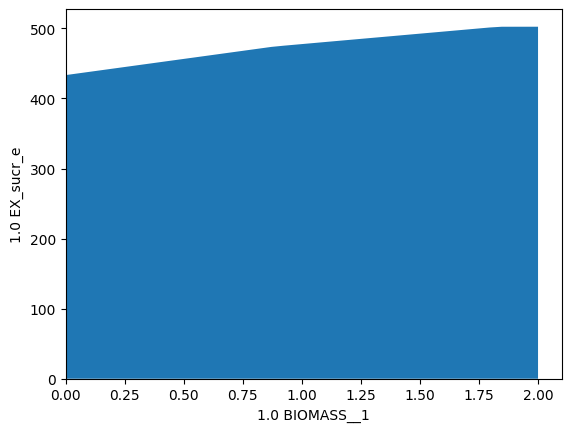

In [18]:

datapoints, triang, plot1 = sd.plot_flux_space(
    model,
    ('BIOMASS__1','EX_sucr_e'),
    show=False
);

In [19]:
blocked_reactions = cobra.flux_analysis.find_blocked_reactions(model)

In [20]:
len(blocked_reactions)

234

In [21]:
consistent_model = cobra.flux_analysis.fastcc(model)

Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp_36irrhy.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp_36irrhy.lp


Reading time = 0.02 seconds


INFO:gurobipy.gurobipy:Reading time = 0.02 seconds


: 893 rows, 1998 columns, 8228 nonzeros


INFO:gurobipy.gurobipy:: 893 rows, 1998 columns, 8228 nonzeros


In [22]:
consistent_model.summary(fva=.9)

INFO:cobra.summary.model_summary:Generating new parsimonious flux distribution.
INFO:cobra.summary.model_summary:Performing flux variability analysis.


Metabolite,Reaction,Flux,Range,C-Number,C-Flux
cobalt2_e,EX_cobalt2_e,1.023E-05,[9.211E-06; 1.023E-05],0,0.00%
fe3_e,EX_fe3_e,0.003204,[0.002884; 0.003204],0,0.00%
k_e,EX_k_e,3.094E-06,[2.785E-06; 3.094E-06],0,0.00%
mg2_e,EX_mg2_e,0.02242,[0.02018; 0.02242],0,0.00%
na1_e,EX_na1_e,2.38E-07,[2.142E-07; 2.38E-07],0,0.00%
nh4_e,EX_nh4_e,16.12,[0; 16.12],0,0.00%
photon650_e,EX_photon650_e,0.02242,[0; 1000],0,0.00%
photon690_e,EX_photon690_e,146.1,[0; 1000],0,0.00%
so4_e,EX_so4_e,0.3115,[0.2803; 0.3115],0,0.00%
Metabolite,Reaction,Flux,Range,C-Number,C-Flux


In [23]:
consistent_model.slim_optimize()

2.0

In [24]:
model.slim_optimize()

2.0

In [25]:
for rxn in consistent_model.metabolites.sucr_c.reactions:
    print(rxn)
    # print(consistent_model.reactions.get_by_id(rxn.id))

SUCRt2: h_e + sucr_e <=> h_c + sucr_c
SPP: h2o_c + suc6p_c --> pi_c + sucr_c
SUCR: h2o_c + sucr_c --> fru_c + glc__D_c


In [26]:
consistent_model.metabolites.suc6p_c

Metabolite identifier,suc6p_c
Name,Sucrose 6-phosphate
Memory address,0x02345264e440
Formula,C12H21O14P
Compartment,c
In 2 reaction(s),"SPP, SPS"


In [27]:
for rxn in consistent_model.metabolites.suc6p_c.reactions:
    print(rxn)

SPP: h2o_c + suc6p_c --> pi_c + sucr_c
SPS: f6p_c + udpg_c --> h_c + suc6p_c + udp_c


In [36]:
# module_optknock = sd.SDModule(
#     consistent_model,
#     names.OPTKNOCK,
#     inner_objective='BIOMASS__1',
#     outer_objective='EX_sucr_e',
#     constraints=['EX_sucr_e >= 11.1', 'BIOMASS__1 >= 1.']
# )

In [37]:
# import logging
# logging.basicConfig(level=logging.INFO)

# sols = sd.compute_strain_designs(
#     consistent_model,
#     sd_modules = module_optknock,
#     max_solutions = 3,
#     max_cost = 4,
#     solution_approach = 'best',
#     time_limit=300,

# )

INFO:root:Preparing strain design computation.
INFO:root:  Using gurobi for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Compressing Network (739 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 238 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Last step could not reduce size further (238 reactions).
INFO:root:  Network compression completed. (1 compression iterations)
INFO:root:  Translating stoichiometric coefficients back to float.
INFO:root:  FVA(s) in compressed model to identify essential reactions.
INFO:root:Finished preprocessing:
INFO:root:  Model size: 238 reactions, 137 metabolites
INFO:root:  165 targetable reactions
INFO

In [38]:
#sols.reaction_sd

[{'PDH': -1.0, 'GND': -1.0, 'PSP_L': -1.0},
 {'PDH': -1.0, 'GND': -1.0, 'PGCD': -1.0},
 {'PDH': -1.0, 'GND': -1.0, 'PSERT': -1.0},
 {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSP_L': -1.0},
 {'PDH': -1.0, 'G6PDH2r': -1.0, 'PGCD': -1.0},
 {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSERT': -1.0},
 {'PDH': -1.0, 'PGL': -1.0, 'PSP_L': -1.0},
 {'PDH': -1.0, 'PGL': -1.0, 'PGCD': -1.0},
 {'PDH': -1.0, 'PGL': -1.0, 'PSERT': -1.0},
 {'GART': -1.0, 'PDH': -1.0, 'GND': -1.0, 'PSP_L': -1.0},
 {'GART': -1.0, 'PDH': -1.0, 'GND': -1.0, 'PGCD': -1.0},
 {'GART': -1.0, 'PDH': -1.0, 'GND': -1.0, 'PSERT': -1.0},
 {'GART': -1.0, 'PDH': -1.0, 'G6PDH2r': -1.0, 'PSP_L': -1.0},
 {'GART': -1.0, 'PDH': -1.0, 'G6PDH2r': -1.0, 'PGCD': -1.0},
 {'GART': -1.0, 'PDH': -1.0, 'G6PDH2r': -1.0, 'PSERT': -1.0},
 {'GART': -1.0, 'PDH': -1.0, 'PGL': -1.0, 'PSP_L': -1.0},
 {'GART': -1.0, 'PDH': -1.0, 'PGL': -1.0, 'PGCD': -1.0},
 {'GART': -1.0, 'PDH': -1.0, 'PGL': -1.0, 'PSERT': -1.0},
 {'PDH': -1.0, 'GND': -1.0, 'PSP_L': -1.0, 'FALGTHLs': -1.0},
 {

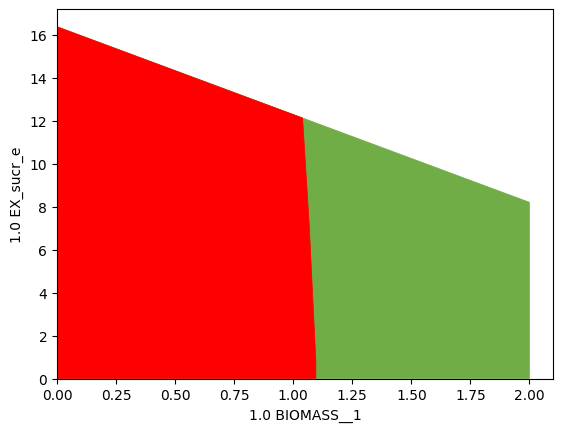

In [39]:

datapoints, triang, plot1 = sd.plot_flux_space(
    consistent_model,
    ('BIOMASS__1', 'EX_sucr_e'),
    show=False
);

plot1.set_facecolor('#70AD47')
plot1.set_edgecolor('#70AD47')

# OptKnock design plot
# interventions = [[{s:1.0},'=',0.0] for rxn in sols.reaction_sd for s,v in rxn.items() if v < 1]
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_, _,plot3 = sd.plot_flux_space(
    consistent_model,
    ('BIOMASS__1','EX_sucr_e'),
    # The sign of the glucose exchange reaction is flipped since
    # reaction is defined in the direction of secretion.
    constraints=interventions,
    # constraints='EX_sucr_e >= 15.5',
    show=False
);
plot3.set_facecolor('red')
plot3.set_edgecolor('red')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

In [47]:
print(interventions)
rxns = set()
for i in sols.reaction_sd:
    for j in i:
        rxns.add(j)
print(rxns)

{'PSERT', 'ALCD1', 'PGL', 'SFGTHi', 'G6PDH2r', 'FALDH2', 'PSP_L', 'GART', 'PGCD', 'GND', 'FALGTHLs', 'PDH'}


In [28]:
rxn_to_remove = {'PSERT', 'ALCD1', 'PGL', 'SFGTHi', 'G6PDH2r', 'FALDH2', 'PSP_L', 'GART', 'PGCD', 'GND', 'FALGTHLs', 'PDH'}
rxn_to_remove

{'ALCD1',
 'FALDH2',
 'FALGTHLs',
 'G6PDH2r',
 'GART',
 'GND',
 'PDH',
 'PGCD',
 'PGL',
 'PSERT',
 'PSP_L',
 'SFGTHi'}

In [29]:
ex=ex+['BIOMASS__1']

In [32]:
with model as model:
    for i in rxn_to_remove:
        model.remove_reactions([model.reactions.get_by_id(i)])
    # model.remove_reactions([model.reactions.get_by_id('VALTA')])
    # model.remove_reactions([model.reactions.get_by_id('PSP_L')])

    # model.remove_reactions([model.reactions.get_by_id('PGCD')])
    # model.remove_reactions([model.reactions.get_by_id('PSERT')])
    # model.remove_reactions([model.reactions.get_by_id('PDH')])
    # model.remove_reactions([model.reactions.get_by_id('G6PDH2r')])
    # model.remove_reactions([model.reactions.get_by_id('GND')])
    print(model.slim_optimize())
    model.objective = {model.reactions.get_by_id('EX_sucr_e'): 1, model.reactions.get_by_id('BIOMASS__1'):10}
    print(model.slim_optimize())
    pfba_solution = cobra.flux_analysis.pfba(model)
    print(pfba_solution)
    fluxes = pfba_solution.fluxes
    prices = pfba_solution.shadow_prices

1.0881347815856053
490.1227594944903
<Solution 26559.255 at 0x23452b8e9b0>


In [ ]:
cobra.io.write_sbml_model( consistent_model, 'condensed_syn.xml',)

In [43]:
cobra.io.save_json_model( model, 'name_for_now.json',)

In [34]:
import escher
from escher import Builder

In [35]:
builder = Builder()

In [40]:
builder.model = model

In [44]:
builder.metabolite_data = pfba_solution.shadow_prices
builder.reaction_data = pfba_solution.fluxes

In [42]:
builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…

In [58]:
with model:
    model.objective = {model.reactions.get_by_id('EX_sucr_e'): 1, model.reactions.get_by_id('BIOMASS__1'):5}
    pfba_solution = cobra.flux_analysis.pfba(model)
builder.metabolite_data = pfba_solution.shadow_prices
builder.reaction_data = pfba_solution.fluxes

In [47]:
flux = pfba_solution.fluxes.to_dict()

## Auto escher map

This code is based on https://github.com/johncthomas/Auto-Escher-map-for-CobraPy.
It doesn't quite do the visualization as wanted, but I'll keep it here until I get a defined escher map working right.

In [45]:
import generate_emap

In [56]:
excluded_reactions = set(ex)

common_mets = set()
rxn_with_flux = set()
rxn_with_greater_flux = set()

threshold_flux = 1.1

# Get a list of reactions with flux and those where flux exceeds the threshold
# The rxn_with_flux will be used to determine what's a common metabolite
# rxn_with_greater flux used to draw the map
for rxn_name in flux:
    if flux[rxn_name] != 0 and rxn_name not in excluded_reactions:
        rxn = model.reactions.get_by_id(rxn_name)
        rxn_with_flux.add(rxn)
        if 0-threshold_flux > flux[rxn_name] or threshold_flux < flux[rxn_name]:
            rxn_with_greater_flux.add(rxn)

# Get a dictionary of metabolite frequency
# (keys are the Cobra metabolite objects)
met_count = generate_emap.metabolite_occurence(rxn_with_flux)

# Get common metabolites.
# included_common_m will be used be treated as uncommon whatever their occurence
included_common_m = ('accoa_c', 'pry_c', 'g3p_c', 'acald_c', 'f6p_c', 'pep_c')
for met in met_count:
    if met_count[met] > 25 and met.id not in included_common_m:
        common_mets.add(met)

# Convert the sets to lists so that they can be iterated over
common_mets, rxn_with_flux, rxn_with_greater_flux = \
    list(common_mets), list(rxn_with_flux), list(rxn_with_greater_flux)


# Get the Escher JSON
escher_map = generate_emap.gen_map(
     consistent_model, rxn_with_greater_flux,  common_mets, 400, met_count
)
escher_json = escher_map.dump_json()
# Currently Escher doesn't accept json strings, needs a file, i assume that's a bug
with open('escher.json', 'w') as f:
    f.write(escher_json)

Of 98 reactions 75 have a link
The following are only connected to other reactions by common intermediates
Modeling: demand reaction (succ c) [DM_succ_c]::  succ_c --> 
Nitrate exchange [EX_no3_e]::  no3_e <=> 
Nucleoside-diphosphate kinase (ATP:GDP) [NDPK1]::  atp_c + gdp_c <=> adp_c + gtp_c
Adenylate kinase [ADK1]::  amp_c + atp_c <=> 2.0 adp_c
Polyphosphate kinase [PPK]::  atp_c + pi_c <=> adp_c + ppi_c
Modeling: exchange reaction, photon absorption (680-700nm)  [EX_photon690_e]::  photon690_e <=> 
Modeling: exchange reaction, photon absorption (660nm-680nm)  [EX_photon670_e]::  photon670_e <=> 
H2O transport via diffusion (tilacoid) [H2Otu_syn]::  h2o_u <=> h2o_c
Modeling: exchange reaction, photon absorption (500nm-520nm) [EX_photon510_e]::  photon510_e <=> 
Acetate kinase [ACKr]::  ac_c + atp_c <=> actp_c + adp_c
Sucrose transport in via proton symport [SUCRt2]::  h_e + sucr_e <=> h_c + sucr_c
Sedoheptulose-bisphosphatase [SBP]::  h2o_c + s17bp_c --> pi_c + s7p_c
Unconnected coun

In [53]:
builder.hide_secondary_metabolites = True

In [54]:
rxn_to_remove

{'ALCD1',
 'FALDH2',
 'FALGTHLs',
 'G6PDH2r',
 'GART',
 'GND',
 'PDH',
 'PGCD',
 'PGL',
 'PSERT',
 'PSP_L',
 'SFGTHi'}

In [51]:
builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…